In [100]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import plotly.express as px

from src.models.qsar_OLS_pca import *
from src.utils.plotting_pred_utils import *

In [101]:
# Load the data
df = pd.read_csv("src/data/IC50_df.csv")

_____________________
Example of one model train on one CDK compared against a random model. It is clear that the OLS model performs better than the random model.


In [102]:
import warnings
from rdkit import RDLogger

# Suppress Pandas warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

In [103]:
cdk = ["Cyclin-dependent kinase 2/G1/S-specific cyclin-E1"]

model_1, X_train, X_test, y_train, y_test, scaler_1, pca_1 = create_model(df, cdk)

[0 0 0 ... 0 0 0]


R2 of the original model:  0.8041482518828735
R2 of the shuffled model:  0.1527244285869893
RMSE of the original model:  1.3346782885127966
RMSE of the shuffled model:  2.7760367564047352


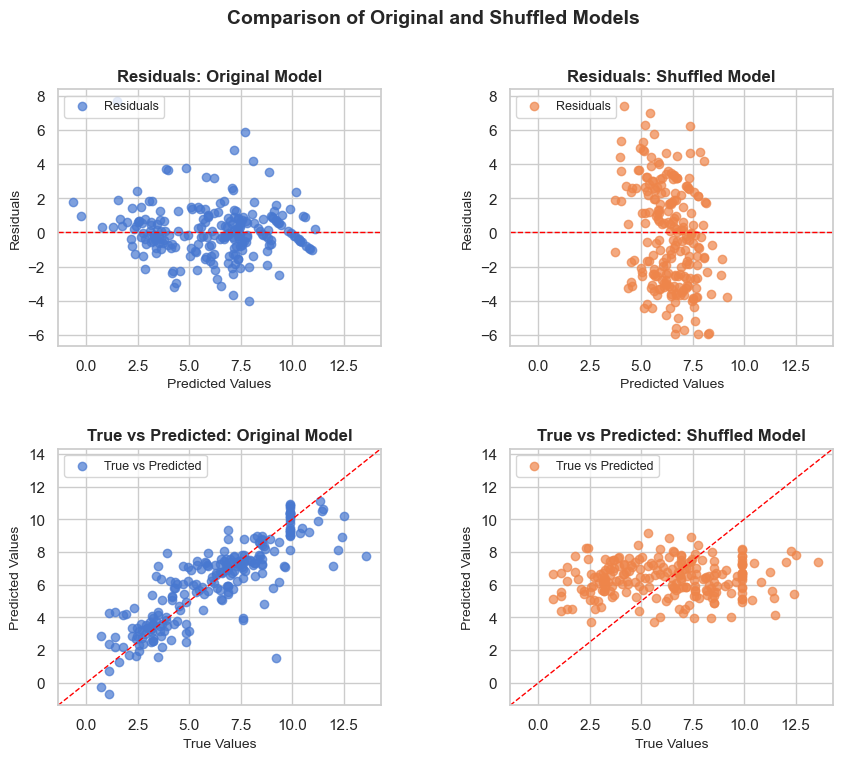

In [104]:
# Compare the CDK OLS model to a random model (predicting on the chosen CDK's test data)
compare_cdkmodel_and_shuffled(model_1, y_train=y_train, X_train=X_train, y_test=y_test, X_test=X_test)

___________
Make one model for each of the CDKs

In [105]:
# Count how many samples each CDK has
count = df["Target Name"].value_counts()

# Choose the CDKs which all contains at least 100 samples
top_k_cdks = count[count >= 100].index
# Print the top k CDKs as well as their count
for cdk in top_k_cdks:
    print(f"{cdk}: {count[cdk]}")
print(f"\nThere are {len(top_k_cdks)} CDKs which all contains at least 100 samples")

Cyclin-dependent kinase 2/G1/S-specific cyclin-E1: 1206
Cyclin-dependent kinase 4/G1/S-specific cyclin-D1: 901
Cyclin-A2/Cyclin-dependent kinase 2: 893
Cyclin-dependent kinase 2: 761
Cyclin-dependent kinase 4: 714
Cyclin-dependent kinase 9: 526
Cyclin-dependent kinase/G2/mitotic-specific cyclin- 1: 520
Cyclin-dependent kinase 1: 481
Cyclin-dependent kinase 1/G2/mitotic-specific cyclin-B: 464
Cyclin-T1/Cyclin-dependent kinase 9: 405
Cyclin-dependent kinase 6: 271
Cyclin-dependent kinase 5 activator 1 [99-307]: 268
Cyclin-dependent kinase 4/G1/S-specific cyclin-D1 [L188C]: 223
Cyclin-A2 [171-432]/Cyclin-dependent kinase 2: 138

There are 14 CDKs which all contains at least 100 samples


We need to comment on how balanced the different CDKs are.

The model will predict according to the input!

Compute the average over each model (i.e. we are doing folds so we split the data into different train and test splits):

In [ ]:
# Creating a model for each of the top CDKs.
# Computing the average of r2 and rmse for each of the models.
r2_means = []
rmse_means = []
for cdk in top_k_cdks:
    r2_s, r2_mean, rmse_s, rmse_mean = compute_average_r2_rmse(df, cdk, [42,43,92,19,20,64,41,23,55,12])
    r2_means.append(r2_mean)
    rmse_means.append(rmse_mean)

Now we have a len14 list of the rmse_means and a len14 list of the r2_means for the 14 different CDKs.

Reporting these mean scores will give a more robust measure of the models for the different CDKs

Plotting the r2 and rmse average for each of the top > 100 samples CDKs:

In [107]:
# Create a DataFrame for the R2 and RMSE values
df_combined = pd.DataFrame({
    "CDK": top_k_cdks,
    "R2": r2_means,
    "RMSE": rmse_means
})

# Sorting descending by R2
df_combined = df_combined.sort_values(by="R2", ascending=False)

# Display the resulting DataFrame
print(df_combined)

                                                  CDK        R2      RMSE
3                           Cyclin-dependent kinase 2  0.963636  0.662802
13      Cyclin-A2 [171-432]/Cyclin-dependent kinase 2  0.926902  0.957657
7                           Cyclin-dependent kinase 1  0.904950  0.932429
12  Cyclin-dependent kinase 4/G1/S-specific cyclin...  0.856960  1.409153
1   Cyclin-dependent kinase 4/G1/S-specific cyclin-D1  0.830426  1.328631
0   Cyclin-dependent kinase 2/G1/S-specific cyclin-E1  0.812906  1.307605
11     Cyclin-dependent kinase 5 activator 1 [99-307]  0.781252  1.684726
6   Cyclin-dependent kinase/G2/mitotic-specific cy...  0.771930  1.314033
8   Cyclin-dependent kinase 1/G2/mitotic-specific ...  0.763790  1.360836
2                 Cyclin-A2/Cyclin-dependent kinase 2  0.732375  1.535539
10                          Cyclin-dependent kinase 6  0.690382  1.043116
9                 Cyclin-T1/Cyclin-dependent kinase 9  0.650142  1.019062
5                           Cyclin-dep

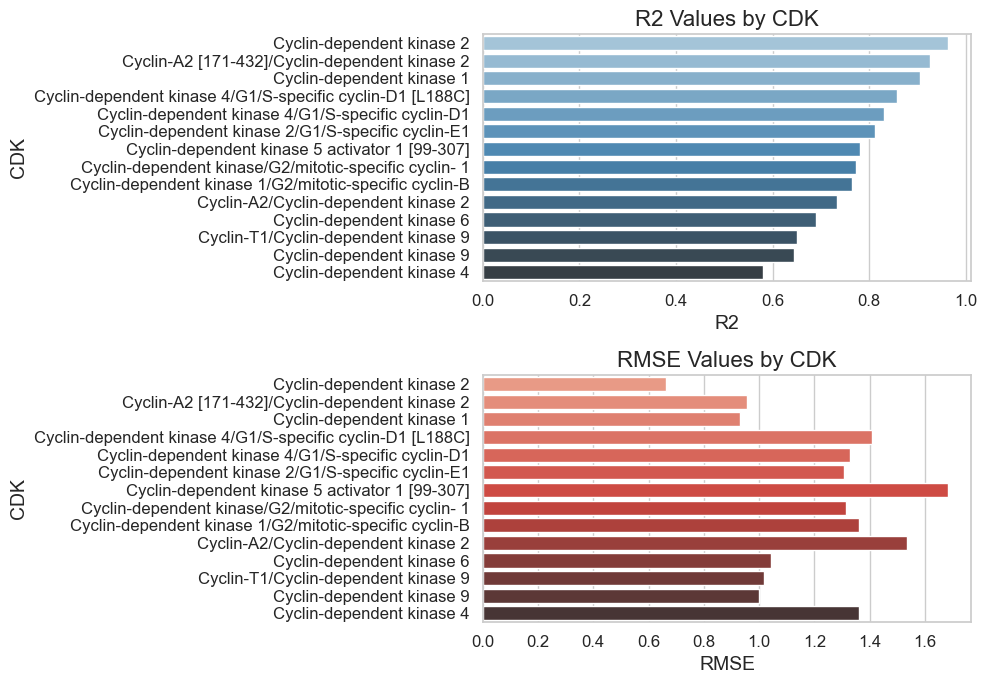

In [108]:
# Suppress the warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Use Seaborn style for better aesthetics
sns.set_theme(style="whitegrid")

# Create the plot
fig, ax = plt.subplots(2, 1, figsize=(10, 7))

# Plot R2
sns.barplot(y="CDK", x="R2", data=df_combined, palette="Blues_d", ax=ax[0])
ax[0].set_title("R2 Values by CDK", fontsize=16)
ax[0].set_xlabel("R2", fontsize=14)
ax[0].set_ylabel("CDK", fontsize=14)
ax[0].tick_params(labelsize=12)

# Plot RMSE
sns.barplot(y="CDK", x="RMSE", data=df_combined, palette="Reds_d", ax=ax[1])
ax[1].set_title("RMSE Values by CDK", fontsize=16)
ax[1].set_xlabel("RMSE", fontsize=14)
ax[1].set_ylabel("CDK", fontsize=14)
ax[1].tick_params(labelsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


________________

maybe note the p values....?

__________________
Spearman correlation

Testing out the spearman correlation between the features in our model. 

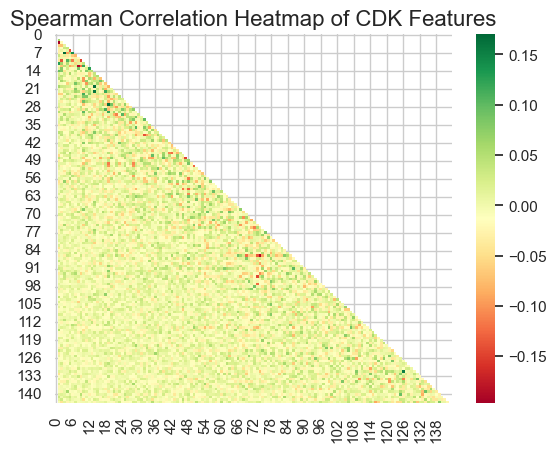

In [109]:
df_X_train = pd.DataFrame(X_train)
spearman_corr = df_X_train.corr(method="spearman")

# Create a mask to only show the lower triangle of the correlation matrix
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))

# Use Seaborn style for better aesthetics
sns.set_theme(style="whitegrid")
sns.heatmap(spearman_corr, mask=mask, cmap="RdYlGn", annot=False, fmt=".2f")
plt.title("Spearman Correlation Heatmap of CDK Features", fontsize=16)
plt.show()

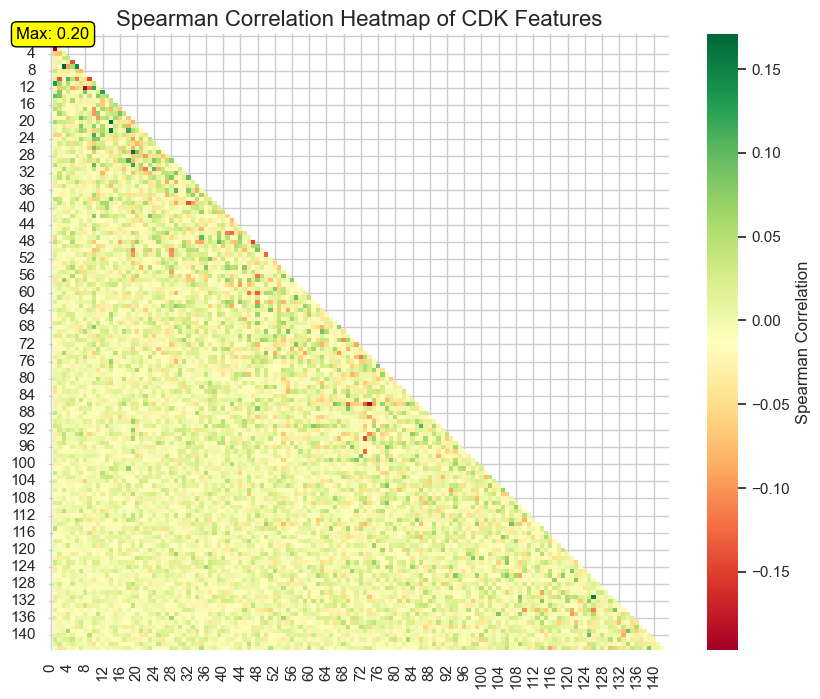

The strongest correlation is 0.20 between Feature 0 and Feature 1.


In [110]:
# Assuming df_X_train is your DataFrame of features
spearman_corr = df_X_train.corr(method="spearman")

# Calculate absolute correlations and find the maximum (off-diagonal)
abs_corr = spearman_corr.abs()
np.fill_diagonal(abs_corr.values, 0)  # Ignore self-correlation (diagonal)
max_corr = abs_corr.max().max()  # Maximum absolute correlation
max_corr_pair = np.unravel_index(abs_corr.values.argmax(), abs_corr.shape)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))

# Set up a meaningful color theme
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.heatmap(
    spearman_corr,
    mask=mask,
    cmap="RdYlGn",  # Meaningful palette
    annot=False,
    fmt=".2f",
    cbar_kws={"label": "Spearman Correlation"},
)

# Annotate the plot with the maximum absolute correlation
plt.title("Spearman Correlation Heatmap of CDK Features", fontsize=16)
plt.text(
    max_corr_pair[1],
    max_corr_pair[0],
    f"Max: {max_corr:.2f}",
    ha="center",
    va="center",
    color="black",
    fontsize=12,
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.3"),
)

plt.show()

# Display the strongest correlation details
print(
    f"The strongest correlation is {max_corr:.2f} between Feature {max_corr_pair[0]} and Feature {max_corr_pair[1]}."
)

______
Prediction part.

We want to predict the binding affinity using the model made on the "Cyclin-dependent kinase 2".

We choose the ligands that has not been tested with this CDK.

In [111]:
# Define the CDK to filter by
cdk = "Cyclin-dependent kinase 2/G1/S-specific cyclin-E1"

# Find all ligands tested with this CDK
tested_ligands = df[df["Target Name"] == cdk]["Ligand SMILES"].drop_duplicates()

# Find ligands NOT tested with this CDK
untested_ligands = df[~df["Ligand SMILES"].isin(tested_ligands)]["Ligand SMILES"].drop_duplicates()

# Convert the untested ligands to a list of SMILES strings
untested_smiles_list = untested_ligands.tolist()

print(f"Found {len(untested_smiles_list)} unique untested ligands for {cdk}.")

Found 3428 unique untested ligands for Cyclin-dependent kinase 2/G1/S-specific cyclin-E1.


In [112]:

model_1, X_train, X_test, y_train, y_test, scaler_1, pca_1 = create_model(df, [cdk], random_state=42)

[0 0 0 ... 0 0 0]


In [113]:
# Run the prediction on the 1000 first of the untested ligands
preds = []
for smiles in untested_smiles_list[:1000]:
    pred = predict_log_affinity(model_1, smiles, scaler_1, pca_1)
    preds.append(pred)


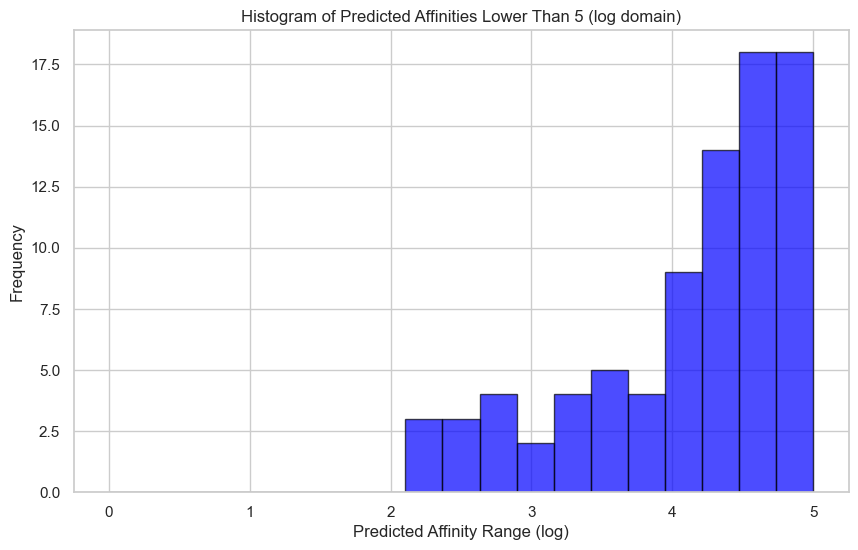

In [114]:
## Make a plot of the predicted affinities but only if the prediction is lower than 5

# Unwrap the arrays and filter values lower than 5
filtered_preds = [float(pred.item()) for pred in preds if float(pred.item()) < 5]

# Check if there are values to plot
if not filtered_preds:
    print("No predictions are lower than 5.")
else:
    # Define bins for the histogram
    bins = np.linspace(0, 5, 20)  # Creates 10 bins between 0 and 5

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_preds, bins=bins, color='blue', edgecolor='black', alpha=0.7)
    plt.xlabel('Predicted Affinity Range (log)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Predicted Affinities Lower Than 5 (log domain)')
    plt.show()

In [115]:
## Print the ligands with the lowest affinities (these will be the most interesting for this CDK)

# Use the SMILES strings from untested_smiles_list as ligand names
ligands = untested_smiles_list[:1000]
affinities = [float(pred.item()) for pred in preds]

# Create and sort DataFrame
df = pd.DataFrame({
    "Ligand (SMILES)": ligands, 
    "Affinity (log)": affinities,
    "Affinity": [np.exp(aff) for aff in affinities]  # reverse the log
}).sort_values("Affinity (log)")

# Display top 10 results
print("Top 10 Predicted Affinities with Cyclin-Dependent Kinase (CDK):\n")
print(df.head(10).to_string(index=False))

Top 10 Predicted Affinities with Cyclin-Dependent Kinase (CDK):

                                         Ligand (SMILES)  Affinity (log)  Affinity
       Nc1nc(Nc2ccc(cc2)S(N)(=O)=O)nn1C(=S)Nc1c(F)cccc1F        2.207954  9.097083
       Nc1nc(Nc2ccc(cc2)S(N)(=O)=O)nn1C(=O)Nc1c(F)cccc1F        2.234492  9.341738
    Nc1nc(Nc2ccc(cc2)S(N)(=O)=O)nn1S(=O)(=O)c1c(F)cccc1F        2.332505 10.303725
 NS(=O)(=O)c1ccc(NN=C2C(=O)Nc3cccc(CCc4ccc(O)cc4)c23)cc1        2.390683 10.920945
        NC(=O)c1cccc2NC(=O)C(=NNc3ccc(cc3)S(N)(=O)=O)c12        2.561223 12.951645
   NS(=O)(=O)c1ccc(NN=C2C(=O)Nc3cccc(-c4cc[nH]n4)c23)cc1        2.577412 13.163024
     Nc1nc(Nc2ccc(cc2)S(N)(=O)=O)n(n1)C(=S)Nc1c(F)cccc1F        2.664860 14.365932
       NS(=O)(=O)c1ccc(NN=C2C(=O)Nc3cccc(c23)N(=O)=O)cc1        2.710284 15.033538
NS(=O)(=O)c1ccc(NN=C2C(=O)Nc3cccc(C=Cc4ccc(O)cc4)c23)cc1        2.722432 15.217287
     Nc1nc(Nc2ccc(cc2)S(N)(=O)=O)nn1C(=O)c1c(F)ccc(F)c1F        2.793593 16.339628


In [116]:
## Another approach.
#  choose 100 random(with seed!) untested ligands with seed 42
random.seed(42)
random_untested_smiles_list = random.sample(untested_smiles_list, 100)
len(random_untested_smiles_list)

100

In [120]:
# Predict the IC50 values for the chosen ligands
predictions = []
predictions_log = []
for smiles in random_untested_smiles_list:
    pred = predict_log_affinity(model_1, smiles, scaler_1, pca_1)
    predictions_log.append(pred)
    predictions.append(np.exp(pred))

In [121]:
# Log domain plot
plot_histogram_log(random_untested_smiles_list, predictions_log)

In [122]:
# Non-log domain plot
plot_histogram_nonlog(random_untested_smiles_list, predictions)

In [123]:
# List the top 10 ligands that have the lowest predicted IC50 values (i.e. will make the strongest binding / inhibition)
top_10 = pd.DataFrame({
    "Ligand SMILES": random_untested_smiles_list,
    "Predicted IC50": predictions
}).sort_values(by="Predicted IC50").head(10)
print(top_10)

                                        Ligand SMILES        Predicted IC50
88  Fc1cccc(F)c1NC(=O)Nc1c[nH]nc1-c1nc2ccc(CN3CCOC...  [11.111990361005534]
84  C[S@](=O)(Cc1cc(Nc2ncc(F)c(n2)-c2ccc(F)cc2F)cc...   [21.96172944864995]
17  CNS(=O)(=O)c1ccc(Nc2nc(OCC3CCCCC3)c3[nH]cnc3n2...    [27.3561431153542]
77  COc1cc(F)ccc1-c1nc(Nc2cc(CS(C)(=O)=NC#N)cc(c2)...  [46.029140271797175]
5   NS(=O)(=O)c1ccc(NN=C2C(=O)Nc3ccc(cc23)N(=O)=O)cc1   [56.38437426857129]
66  C[S@](=N)(=O)Cc1cc(F)cc(Nc2ncc(F)c(n2)-c2ccc(F...    [86.3544457923392]
48  Fc1cc2[nH]c3c(c4C(=O)NC(=O)c4c4c5cccc6CCCn(c56...  [128.07649442141437]
41  COc1ccc(Cc2nc3n(ncc3c(=O)[nH]2)-c2c(Cl)cc(Cl)c...  [143.15460212930668]
25      Brc1ccc2C(=O)\C(Nc2c1)=C1\C(=O)Nc2cc(Br)ccc12  [174.03803527500554]
4   Fc1ccc(Nc2nccc(n2)-c2c(nn3ncccc23)-c2ccc(cc2)C...  [187.98217752522038]


Also try with known ligands used in therapy... I couldn't find any smiles in free articles.

In [124]:
# Listing random ligand SMILES
aspirin_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"
paracetamol_smiles = "CC(=O)Nc1ccc(cc1)O"
ethanol_smiles = "CCO"

smiles_list = [aspirin_smiles, paracetamol_smiles, ethanol_smiles]

# Predicting the affinity of the model from the (actually the last???) CDK with the ligands
for smiles in smiles_list:
    pred = predict_log_affinity(model_1, smiles, scaler_1, pca_1)
    print(f"Expecting prediction for {smiles} (log): {pred}")
    print(f"Expecting prediction for {smiles} (nM): {np.exp(pred)}")


Expecting prediction for CC(=O)OC1=CC=CC=C1C(=O)O (log): [10.45039959]
Expecting prediction for CC(=O)OC1=CC=CC=C1C(=O)O (nM): [34558.18110469]
Expecting prediction for CC(=O)Nc1ccc(cc1)O (log): [10.63202286]
Expecting prediction for CC(=O)Nc1ccc(cc1)O (nM): [41440.86938388]
Expecting prediction for CCO (log): [10.36634133]
Expecting prediction for CCO (nM): [31772.02073168]
